# Model training

In [188]:
import numpy as np
import pandas as pd
import pickle
import os


In [77]:
DATA_SUBDIR = '../data'

##### Importing the data

Here I'll be using the data exported in `data_analysis.ypynb`

In [135]:
data = pd.read_pickle(os.path.join(DATA_SUBDIR, 'train.pkl'))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371848 entries, 388024 to 451283
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   altura                  371848 non-null  int64  
 1   exposicion              371848 non-null  int64  
 2   inclinacion_suelo       371848 non-null  int64  
 3   distancia_agua          371848 non-null  int64  
 4   altura_agua             371848 non-null  int64  
 5   distancia_caminos       371848 non-null  int64  
 6   sombra_maniana          371848 non-null  int64  
 7   sombra_mediodia         371848 non-null  int64  
 8   sombra_tarde            371848 non-null  int64  
 9   distancia_fuego         371848 non-null  int64  
 10  clase_suelo             371848 non-null  int64  
 11  dosel_forestal          371848 non-null  int64  
 12  sombra                  371848 non-null  float64
 13  clase_area_silvestre_1  371848 non-null  uint8  
 14  clase_area_silv

In [79]:
data.head()

,altura,exposicion,inclinacion_suelo,distancia_agua,altura_agua,distancia_caminos,sombra_maniana,sombra_mediodia,sombra_tarde,distancia_fuego,clase_suelo,dosel_forestal,sombra,clase_area_silvestre_1,clase_area_silvestre_2,clase_area_silvestre_3,clase_area_silvestre_4,clase_suelo_10,clase_suelo_39,clase_suelo_38
388024,3372,91,13,603,215,1401,240,219,108,1022,39,7,189.000000,0,0,1,0,0,1,0
254008,2521,42,7,124,13,882,221,225,139,934,6,2,195.000000,0,0,0,1,0,0,0
349506,3197,92,8,85,6,390,233,228,128,1920,22,1,196.333333,1,0,0,0,0,0,0
19002,2803,34,12,90,11,4142,218,213,129,5407,29,1,186.666667,1,0,0,0,0,0,0
456137,2596,247,22,242,133,1500,169,250,214,1342,3,3,211.000000,0,0,1,0,0,0,0


Let's manipulate the data a little more and scale the numerical features

In [136]:
from sklearn.preprocessing import StandardScaler

# Separete the target
target = data['dosel_forestal']
data.drop(['dosel_forestal'], axis=1, inplace=True)

# Separate the categorical features
cat_features = [
	'clase_area_silvestre_1',
	'clase_area_silvestre_2',
	'clase_area_silvestre_3',
	'clase_area_silvestre_4',
	'clase_suelo_10',
	'clase_suelo_39',
	'clase_suelo_38',
	'clase_suelo'
	]

num_data = data.drop(cat_features, axis=1)
cat_data = data[cat_features]

# Scale numerical features
scaler = StandardScaler()
scaled_num_data = scaler.fit_transform(num_data)

Combine all the data

In [137]:
prep_data = np.concatenate([scaled_num_data, cat_data.to_numpy()], axis=1)

## Random Forest

##### Training

Now let us try training a random forest model with the prepared data

In [138]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=10, random_state=1234)
rf_classifier.fit(prep_data, target)
rf_prediction = rf_classifier.predict(prep_data)

Let's compare the prediction with the original data in graphs

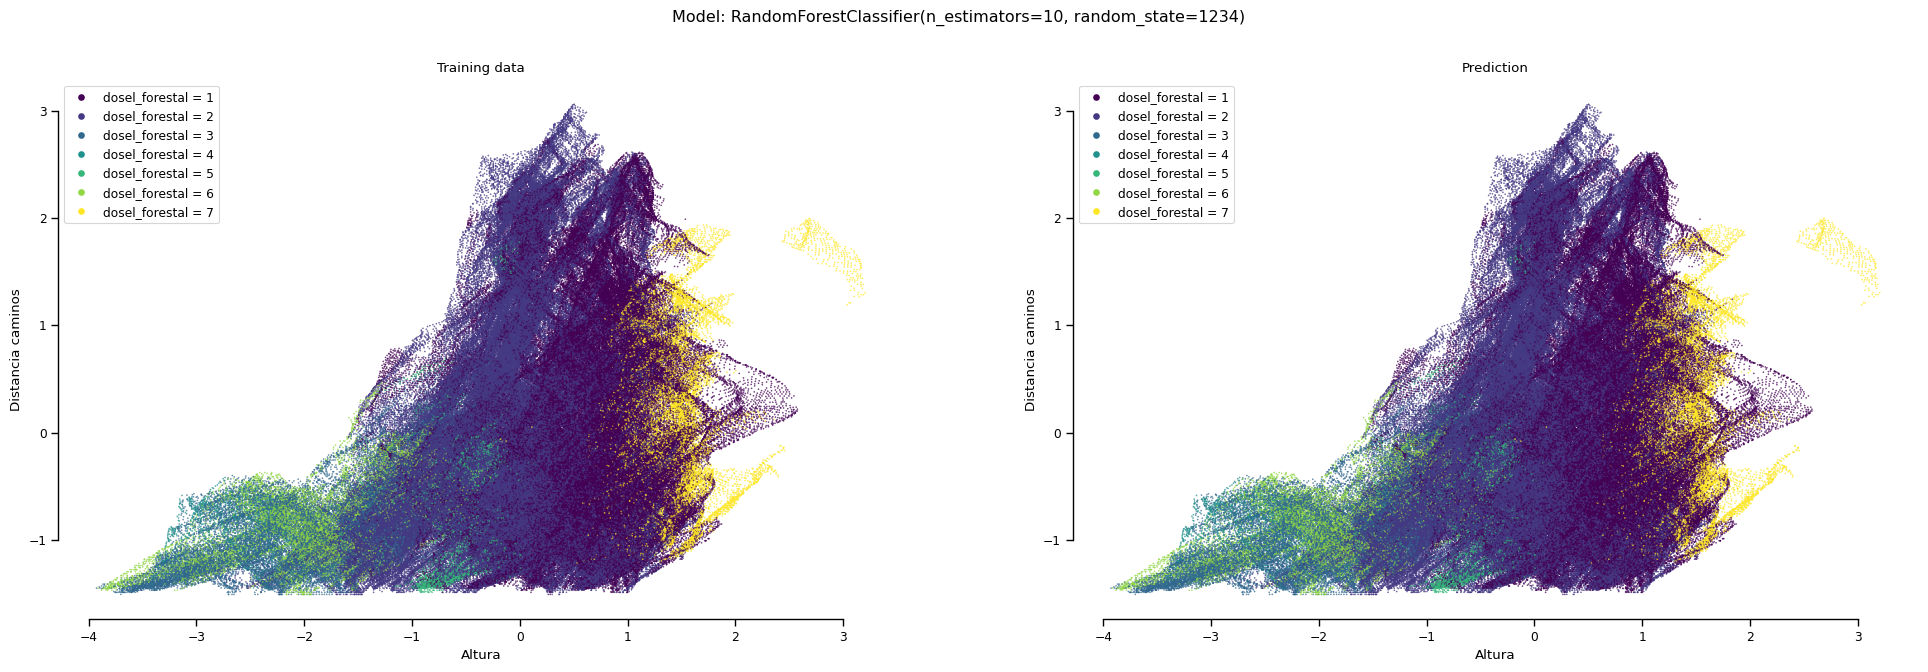

In [139]:
from matplotlib import pyplot as plt

idx_altura = 0; idx_inclinacion_suelo = 2; idx_distancia_caminos = 5; idx_sombra = 11; idx_clase_area_silvestre_4 = 15;


fig = plt.figure(figsize=(24, 7))
fig.suptitle(f'Model: {rf_classifier}')
sns.set_context("paper")

# mask = np.logical_not(prep_data.T[idx_clase_area_silvestre_4].astype('bool'))
ax = fig.add_subplot(121, title="Training data")
ax.scatter(prep_data.T[idx_altura], prep_data.T[idx_distancia_caminos], c=target, s=0.1)

# Legend handles
lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), mec='none', label=f'dosel_forestal = {i:g}', ls='', marker='o')[0]
handles = [lp(i) for i in np.unique(target)]
plt.legend(handles=handles)

ax.set_xlabel("Altura")
ax.set_ylabel("Distancia caminos")

ax = fig.add_subplot(122, title="Prediction")
sc = ax.scatter(prep_data.T[idx_altura], prep_data.T[idx_distancia_caminos], c=rf_prediction, s=0.1)

# Legend handles
handles = [lp(i) for i in np.unique(rf_prediction)]
plt.legend(handles=handles)

ax.set_xlabel("Altura")
ax.set_ylabel("Distancia caminos")

sns.despine(trim=True)

The model seems to do a great job predicting the training data, maybe it is overfitting. Let's check some metrics:

In [140]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

acc = accuracy_score(target.to_numpy(), rf_prediction)
prec = precision_score(target.to_numpy(), rf_prediction, average='macro')
rec = recall_score(target.to_numpy(), rf_prediction, average='macro')

print(f'Accuracy:\t{acc:.8f}\nPrecision:\t{prec:.8f}\nRecall:\t\t{rec:.8f}')

Accuracy:	0.99781362
Precision:	0.99750622
Recall:		0.99361671


These metrics are pretty good but testing against the training set is not a very bold or useful endeavour. Let's do some cross validation.

##### Cross Validation

In [162]:
from sklearn.model_selection import cross_val_score

rf_cv_scores = cross_val_score(rf_classifier, prep_data, target, cv=10)
print(f'Cross Validation score (Accuracy): {rf_cv_scores.mean()} +/- {rf_cv_scores.std()}')

Cross Validation score (Accuracy): 0.9383592205362683 +/- 0.0015530189720320618


Of course, this value is lower than the previously calculated accuracy. Our model might probably benefit from some fine tuning, but first let's see how the model does with the testing partition.

##### Testing

In [148]:
from prep_data import preapare_data

# Import testing set
test_set = pd.read_pickle(os.path.join(DATA_SUBDIR, 'test.pkl'))

# Prepare the testing set
prep_test, test_target = preapare_data(test_set)

In [150]:
# Predict 
rf_test_prediction = rf_classifier.predict(prep_test)

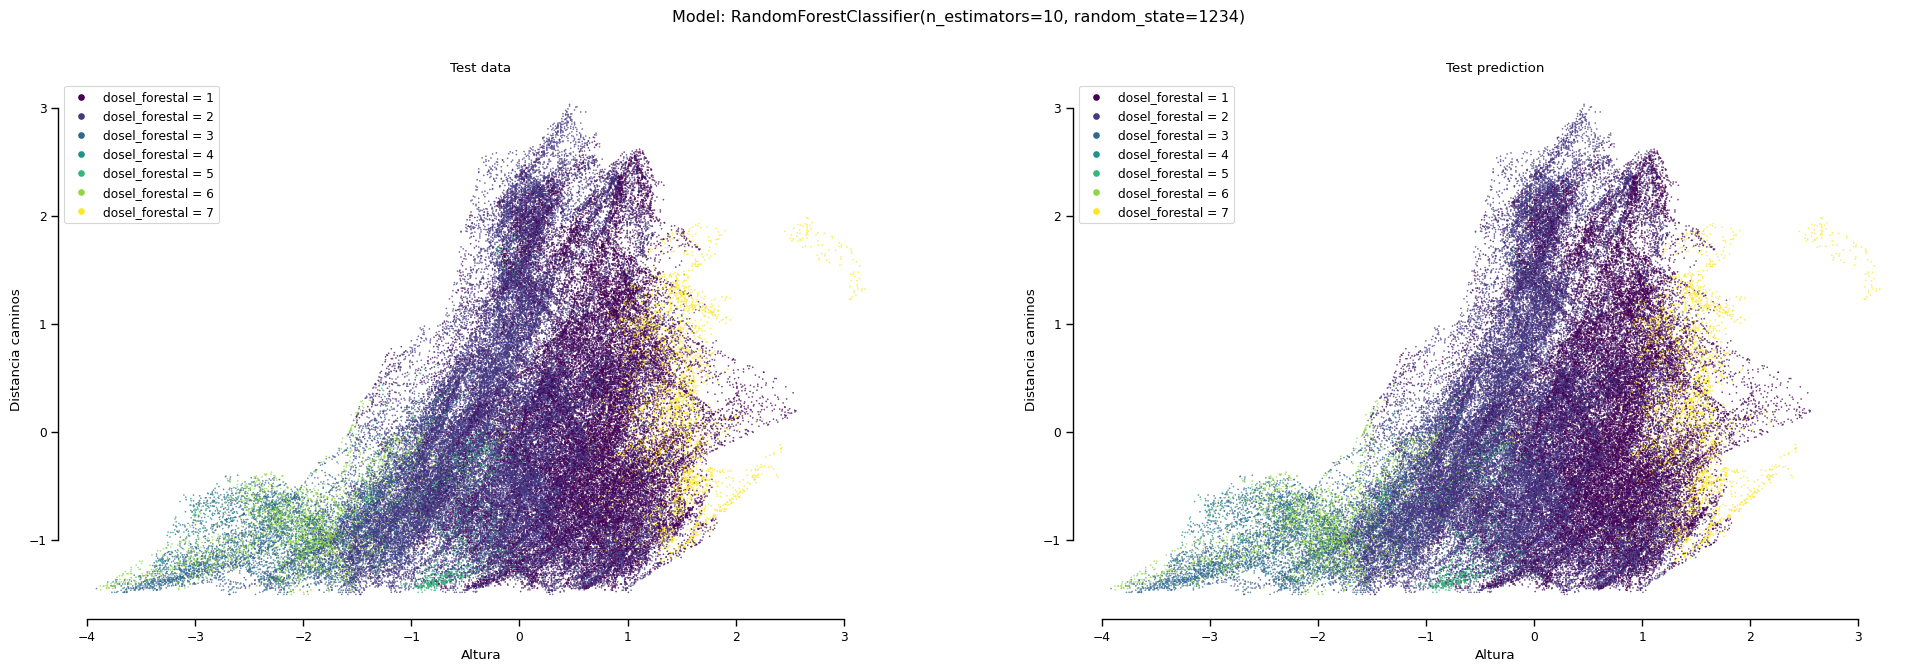

In [151]:
from matplotlib import pyplot as plt

idx_altura = 0; idx_inclinacion_suelo = 2; idx_distancia_caminos = 5; idx_sombra = 11; idx_clase_area_silvestre_4 = 15;


fig = plt.figure(figsize=(24, 7))
fig.suptitle(f'Model: {rf_classifier}')
sns.set_context("paper")

ax = fig.add_subplot(121, title="Test data")
ax.scatter(prep_test.T[idx_altura], prep_test.T[idx_distancia_caminos], c=test_target, s=0.1)

# Legend handles
lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), mec='none', label=f'dosel_forestal = {i:g}', ls='', marker='o')[0]
handles = [lp(i) for i in np.unique(test_target)]
plt.legend(handles=handles)

ax.set_xlabel("Altura")
ax.set_ylabel("Distancia caminos")

ax = fig.add_subplot(122, title="Test prediction")
sc = ax.scatter(prep_test.T[idx_altura], prep_test.T[idx_distancia_caminos], c=rf_test_prediction, s=0.1)

# Legend handles
handles = [lp(i) for i in np.unique(rf_test_prediction)]
plt.legend(handles=handles)

ax.set_xlabel("Altura")
ax.set_ylabel("Distancia caminos")

sns.despine(trim=True)

In [153]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

tacc = accuracy_score(test_target.to_numpy(), rf_test_prediction)
tprec = precision_score(test_target.to_numpy(), rf_test_prediction, average='macro')
trec = recall_score(test_target.to_numpy(), rf_test_prediction, average='macro')

print(f'Accuracy:\t{tacc:.8f}\nPrecision:\t{tprec:.8f}\nRecall:\t\t{trec:.8f}')

Accuracy:	0.94206235
Precision:	0.93125342
Recall:		0.87904999


These metrics are lower than the ones gotten before (of course), but they are still good.

##### Feature importance

In [154]:
importances = rf_classifier.feature_importances_
features = data.columns

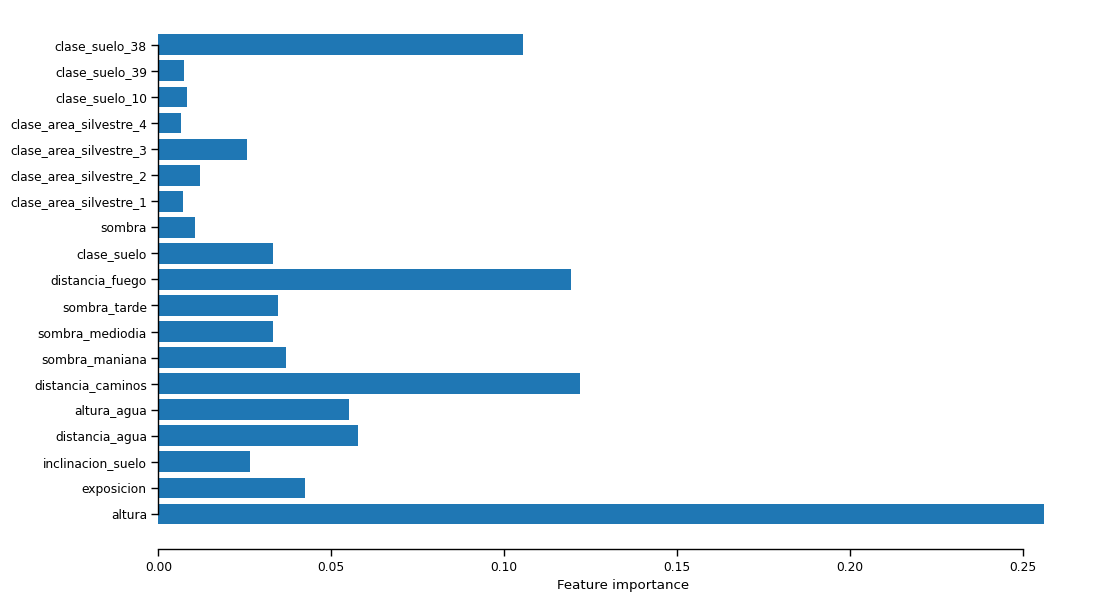

In [155]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.set_context('paper')

ax.barh(features, importances)
ax.set_xlabel('Feature importance')
sns.despine(trim=True)

In [159]:
from sklearn.inspection import permutation_importance

r = permutation_importance(rf_classifier, prep_test, test_target, n_repeats=30, random_state=1234)

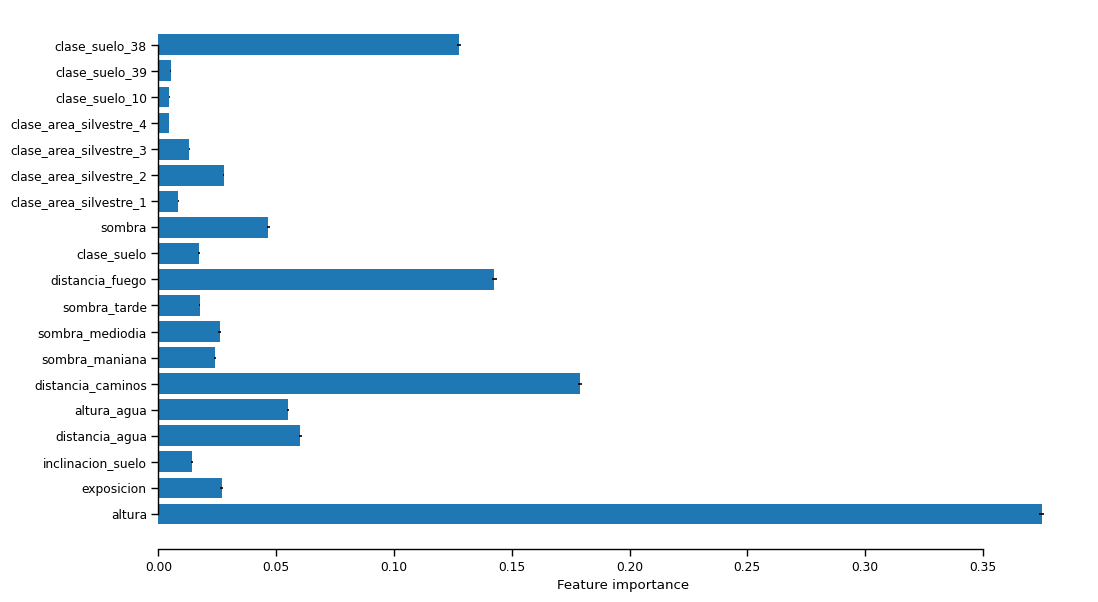

In [181]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.set_context('paper')

ax.barh(features, r.importances_mean, xerr=r.importances_std)
ax.set_xlabel('Feature importance')
sns.despine(trim=True)

Contrary to what I expected the features `clase_area_silvestre_4` is not very important to the model but surprisingly the category 38 of the feature `clase_suelo` is the 4th most important one.

## XGBoost

##### Training

In [164]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier()
xgb_classifier.fit(prep_data, target - 1)
xgb_prediction = xgb_classifier.predict(prep_data) + 1

In [167]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

xgbacc = accuracy_score(target.to_numpy(), xgb_prediction)
xgbprec = precision_score(target.to_numpy(), xgb_prediction, average='macro')
xgbrec = recall_score(target.to_numpy(), xgb_prediction, average='macro')

print(f'Accuracy:\t{xgbacc:.8f}\nPrecision:\t{xgbprec:.8f}\nRecall:\t\t{xgbrec:.8f}')

Accuracy:	0.88724425
Precision:	0.91913417
Recall:		0.88038359


The result is much worse than the result using the Random Forest even for the training set

##### Cross validation

In [171]:
from sklearn.model_selection import cross_val_score

xgb_cv_scores = cross_val_score(xgb_classifier, prep_data, target - 1, cv=10) # this runs for 53 mins
print(f'Cross Validation score (Accuracy): {xgb_cv_scores.mean()} +/- {xgb_cv_scores.std()}')

Cross Validation score (Accuracy): 0.8713909996581728 +/- 0.002976933940938877


##### Testing


In [175]:
xgb_test_prediction = xgb_classifier.predict(prep_test) + 1

In [177]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

xgbacc = accuracy_score(test_target.to_numpy(), xgb_test_prediction)
xgbprec = precision_score(test_target.to_numpy(), xgb_test_prediction, average='macro')
xgbrec = recall_score(test_target.to_numpy(), xgb_test_prediction, average='macro')

print(f'Accuracy:\t{xgbacc:.8f}\nPrecision:\t{xgbprec:.8f}\nRecall:\t\t{xgbrec:.8f}')

Accuracy:	0.87358275
Precision:	0.89285828
Recall:		0.83572634


With these results I conclude that Random Forest is better suited for this case, so I'll try to improve the model.

## Fine tuning

##### Grid search CV

In [184]:
from sklearn.model_selection import GridSearchCV

param_grid = [
	{'bootstrap': [True, False], 'n_estimators': [5, 10, 50], 'max_features': [4, 7, 14, 19]},
]

rf_gscv_classifier = RandomForestClassifier(n_jobs=-1, random_state=1234)

grid_search = GridSearchCV(rf_gscv_classifier, param_grid, cv=10, n_jobs=-1, return_train_score=True, verbose=2.5)
grid_search.fit(prep_data, target)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV 4/10] END bootstrap=True, max_features=4, n_estimators=5;, score=(train=0.993, test=0.927) total time=  14.7s
[CV 1/10] END bootstrap=True, max_features=4, n_estimators=5;, score=(train=0.993, test=0.927) total time=  15.3s
[CV 3/10] END bootstrap=True, max_features=4, n_estimators=5;, score=(train=0.992, test=0.927) total time=  15.4s
[CV 2/10] END bootstrap=True, max_features=4, n_estimators=5;, score=(train=0.993, test=0.925) total time=  15.9s
[CV 5/10] END bootstrap=True, max_features=4, n_estimators=5;, score=(train=0.993, test=0.925) total time=  16.4s
[CV 7/10] END bootstrap=True, max_features=4, n_estimators=5;, score=(train=0.993, test=0.928) total time=  13.8s
[CV 6/10] END bootstrap=True, max_features=4, n_estimators=5;, score=(train=0.993, test=0.925) total time=  14.7s
[CV 8/10] END bootstrap=True, max_features=4, n_estimators=5;, score=(train=0.993, test=0.924) total time=  15.3s
[CV 10/10] END bootstrap=

/home/maxwell/Physics/2. IB/Maestría/[2] Cursos/ML/MLF_Vegetation/venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 7/10] END bootstrap=True, max_features=4, n_estimators=50;, score=(train=1.000, test=0.951) total time= 1.7min
[CV 8/10] END bootstrap=True, max_features=4, n_estimators=50;, score=(train=1.000, test=0.948) total time= 1.7min
[CV 1/10] END bootstrap=True, max_features=7, n_estimators=5;, score=(train=0.994, test=0.941) total time=  18.3s
[CV 2/10] END bootstrap=True, max_features=7, n_estimators=5;, score=(train=0.994, test=0.940) total time=  19.8s
[CV 4/10] END bootstrap=True, max_features=7, n_estimators=5;, score=(train=0.994, test=0.942) total time=  15.9s
[CV 3/10] END bootstrap=True, max_features=7, n_estimators=5;, score=(train=0.994, test=0.940) total time=  21.0s
[CV 5/10] END bootstrap=True, max_features=7, n_estimators=5;, score=(train=0.994, test=0.939) total time=  17.8s
[CV 6/10] END bootstrap=True, max_features=7, n_estimators=5;, score=(train=0.994, test=0.938) total time=  24.8s
[CV 7/10] END bootstrap=True, max_features=7, n_estimators=5;, score=(train=0.994, tes

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=1234),
             n_jobs=-1,
             param_grid=[{'bootstrap': [True, False],
                          'max_features': [4, 7, 14, 19],
                          'n_estimators': [5, 10, 50]}],
             return_train_score=True, verbose=2.5)

In [186]:
best_model = grid_search.best_estimator_

In [189]:
with open('best_model.pkl', 'wb') as file:
	pickle.dump(best_model, file)

Let's see the scores

In [192]:
best_model_pred = best_model.predict(prep_data)

tacc = accuracy_score(target.to_numpy(), best_model_pred)
tprec = precision_score(target.to_numpy(), best_model_pred, average='macro')
trec = recall_score(target.to_numpy(), best_model_pred, average='macro')

print(f'Accuracy:\t{tacc:.8f}\nPrecision:\t{tprec:.8f}\nRecall:\t\t{trec:.8f}')

Accuracy:	1.00000000
Precision:	1.00000000
Recall:		1.00000000


Hmmmm, this smells like overfitting

In [193]:
best_model_test_pred = best_model.predict(prep_test)

tacc = accuracy_score(test_target.to_numpy(), best_model_test_pred)
tprec = precision_score(test_target.to_numpy(), best_model_test_pred, average='macro')
trec = recall_score(test_target.to_numpy(), best_model_test_pred, average='macro')

print(f'Accuracy:\t{tacc:.8f}\nPrecision:\t{tprec:.8f}\nRecall:\t\t{trec:.8f}')

Accuracy:	0.96643790
Precision:	0.95099071
Recall:		0.93184709


It actually performs better than the initial estimator. Let's see how important the features turned out to be

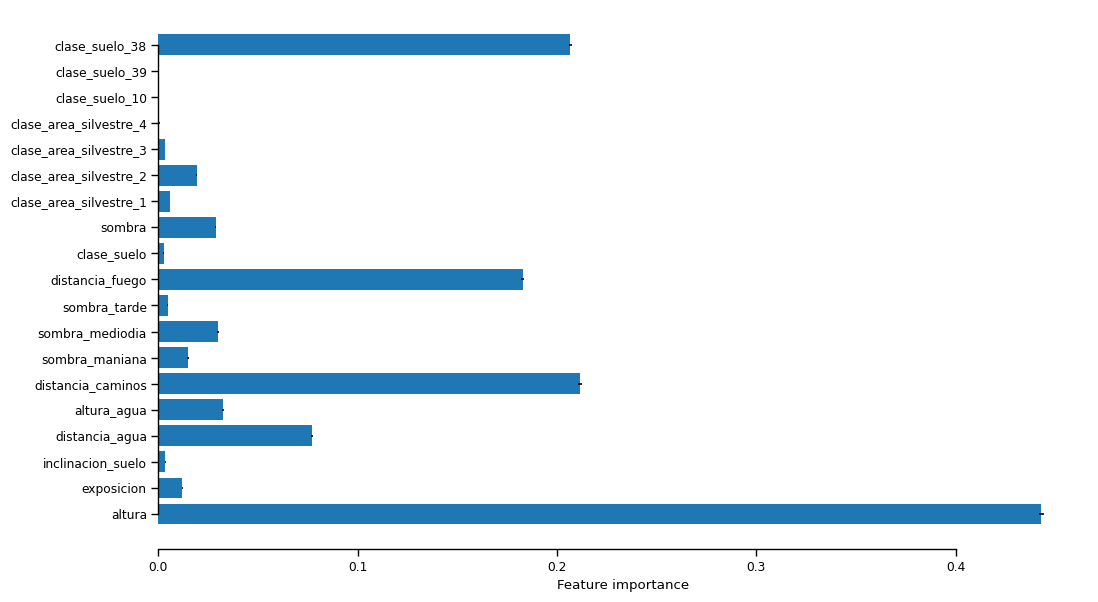

In [194]:
r = permutation_importance(best_model, prep_test, test_target, n_repeats=30, random_state=1234)

fig, ax = plt.subplots(figsize=(12, 7))
sns.set_context('paper')

ax.barh(features, r.importances_mean, xerr=r.importances_std)
ax.set_xlabel('Feature importance')
sns.despine(trim=True)